In [19]:
import pandas as pd
import numpy as np
import pricey as pr
from prophet import Prophet
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import FinanceDataReader as fdr
from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.metrics import silhouette_score
from tqdm.notebook import tqdm
import statsmodels.api as sm
import itertools
from IPython.core.debugger import set_trace
import seaborn as sns
import arviz as az

from sklearnex import patch_sklearn
patch_sklearn()

# import warnings
# warnings.filterwarnings(action='ignore')

import logging
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled=True

from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.preprocessing import StandardScaler, MinMaxScaler#, Imputer
from sklearn.cluster import KMeans, DBSCAN

%matplotlib inline

import pymc as pm
# import aesara as asr
from aesara import shared
import pytensor

az.style.use("arviz-darkgrid")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
univ = pd.read_excel('ticker_map.xlsx', converters={'code':str})
univ = list(univ['code']); univ

['005930',
 '005935',
 '000660',
 '006400',
 '006405',
 '051910',
 '051915',
 '005380',
 '005385',
 '035420',
 '068270',
 '000270',
 '035720',
 '105560',
 '005490',
 '055550',
 '207940',
 '012330',
 '373220',
 '028260',
 '086790',
 '033780',
 '066570',
 '066575',
 '096770',
 '316140',
 '017670',
 '034730',
 '003550',
 '030200',
 '009150',
 '259960',
 '036570',
 '323410',
 '000810',
 '009830',
 '015760',
 '032830',
 '051900',
 '010130',
 '011200',
 '003490',
 '034020',
 '003670',
 '011070',
 '018260',
 '402340',
 '028050',
 '009540',
 '010950',
 '010140',
 '352820',
 '047810',
 '097950',
 '090430',
 '034220',
 '021240',
 '000100',
 '035250',
 '086280',
 '032640',
 '251270',
 '000720',
 '011170',
 '267250',
 '004020',
 '024110',
 '161390',
 '377300',
 '010620',
 '005830',
 '011780',
 '008770',
 '383220',
 '271560',
 '006800',
 '329180',
 '071050',
 '012450',
 '018880',
 '078930',
 '016360',
 '011790',
 '001450',
 '139480',
 '010060',
 '128940',
 '138930',
 '004170',
 '030000',
 '302440',

In [5]:
_dflist = [fdr.DataReader(code, '2019-01-01') for code in tqdm(univ)]

  0%|          | 0/147 [00:00<?, ?it/s]

In [6]:
p = pd.concat([_s['Close'] for _s in _dflist], axis=1)
p.columns = univ
logp = np.log(p); logp.head()

,005930,005935,000660,006400,006405,051910,051915,005380,005385,035420,...,006650,192820,003850,105630,069500,232080,261220,132030,261240,148070
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,10.564886,10.360912,11.012050,12.257241,11.359774,12.727838,12.162643,11.643954,11.136048,11.678440,...,11.901583,11.716111,8.930230,9.888374,10.089386,9.335209,9.684398,9.148465,9.170560,11.653661
2019-01-03,10.534759,10.335270,10.963012,12.220961,11.326596,12.700769,12.136187,11.665647,11.153389,11.711776,...,11.845820,11.704033,8.909100,9.849559,10.079623,9.311813,9.697693,9.152711,9.178850,11.653991
2019-01-04,10.530762,10.323841,10.973357,12.211060,11.304671,12.708362,12.122691,11.691072,11.161949,11.740061,...,11.820410,11.724077,8.916238,9.880731,10.087225,9.330343,9.736547,9.154828,9.176266,11.651600
2019-01-07,10.564886,10.376611,10.980195,12.287653,11.357441,12.745486,12.154779,11.699405,11.159104,11.786762,...,11.904968,11.739822,8.930230,9.935471,10.101313,9.337678,9.764800,9.151121,9.170039,11.652009
2019-01-08,10.547970,10.338511,10.988677,12.294541,11.363265,12.764259,12.173033,11.691072,11.154821,11.775290,...,11.877569,11.739822,8.924124,9.987369,10.094934,9.325542,9.760194,9.146335,9.174195,11.650773


In [7]:
p_open = pd.concat([_s['Open'] for _s in _dflist], axis=1)
p_open.columns = univ; p_open.tail()

,005930,005935,000660,006400,006405,051910,051915,005380,005385,035420,...,006650,192820,003850,105630,069500,232080,261220,132030,261240,148070
Date,,,,,,,,,,,,,,,,,,,,,
2023-04-03,64000,54300,89700,750000,338000,728000,318000,184600,94600,203500,...,183200,80600,8750,15660,32785,13070,14600,12780,11770,112000
2023-04-04,63400,53800,85700,740000,337000,717000,320500,184000,94700,198200,...,173500,80200,8730,15570,32555,12910,14615,12955,11820,111680
2023-04-05,63700,53300,84300,730000,343500,722000,323500,185100,94100,201000,...,172300,80600,8900,15730,32680,13015,14695,13195,11860,111960
2023-04-06,63500,53400,83900,764000,345500,728000,327000,186900,94900,198200,...,171500,79900,8940,15400,32720,13350,14610,13190,11900,112120
2023-04-07,63800,54100,87900,742000,340000,720000,321000,185400,94300,193000,...,171100,80200,8950,15090,32510,13210,14630,13115,11920,113300


In [172]:
pairs = [
    ['005930', '005935'], # 삼성전자
    ['066570', '066575'], # LG전자
    ['006400', '006405'], # 삼성SDI
    ['051910', '051915'], # LG화학
    ['005380', '005385'], # 현대차
]

_from, _to = '2019-01-01', '2023-04-07'

stock1_name, stock2_name = pairs[4]
orig_data = logp.loc[_from:_to,[stock1_name, stock2_name]]
p_data = p.loc[_from:_to,[stock1_name, stock2_name]]
p_open_data = p_open.loc[_from:_to,[stock1_name, stock2_name]]

data = orig_data.diff().cumsum()
data1 = data[stock1_name].ffill().fillna(0).values
data2 = data[stock2_name].ffill().fillna(0).values

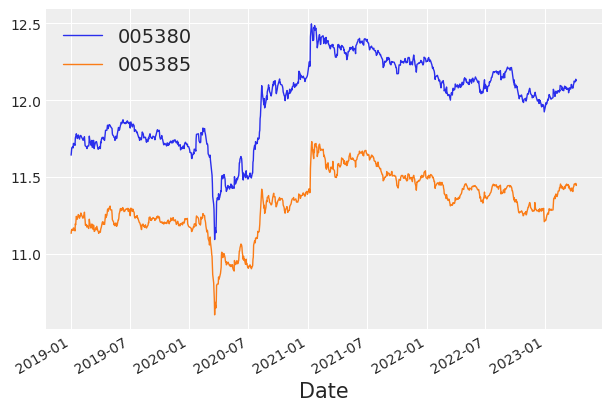

In [173]:
plt.figure(figsize = (6,4))
ax = plt.gca()
# plt.title("Potentially Cointegrated Stocks")
orig_data[stock1_name].plot(ax=ax,linewidth=1, fontsize=10)
orig_data[stock2_name].plot(ax=ax,linewidth=1, fontsize=10)
# plt.ylabel("Price")
plt.legend()
plt.show()

<Axes: xlabel='Date'>

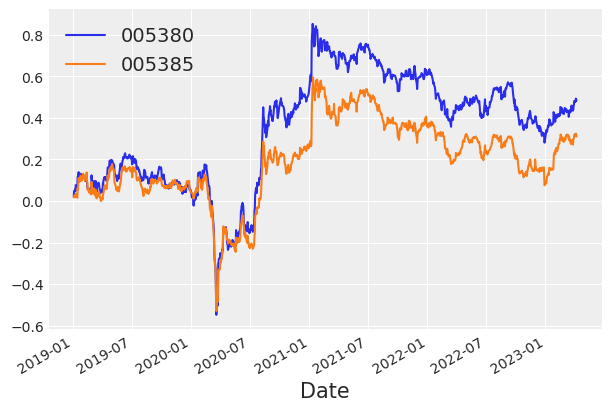

In [174]:
data[[stock1_name, stock2_name]].plot(figsize=(6,4), fontsize=10)

In [175]:
data.shape

(1055, 2)

In [176]:
with pm.Model() as model:
    
#     stock1 = data1
#     stock2 = data2
    
    stock1 = pytensor.shared(data1)
    stock2 = pytensor.shared(data2)
    
    # define our cointegration variables
    beta_sigma = pm.Exponential('beta_sigma', 50.)
    beta = pm.GaussianRandomWalk('beta', sigma=beta_sigma, shape=data1.shape[0], init_dist=pm.Normal.dist(0, 10))
    
    # with our assumptions, cointegration can be reframed as a regression problem
    stock2_regression = beta * stock1
    
    # Assume prices are Normally distributed, the mean comes from the regression.
    sd = pm.HalfNormal('sd', sigma=.1)
    likelihood = pm.Normal('y', mu=stock2_regression, sigma=sd, observed=stock2)

with model:
    stock1.set_value(data1)
    stock2.set_value(data2)
    idata = pm.sample(chains=2, cores=8, random_seed=0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 8 jobs)
NUTS: [beta_sigma, beta, sd]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 25 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [429]:
# with pm.Model() as model:
#     model.add_coord('dates', data.index[:250], mutable = True)
#     stock1 = pm.MutableData('stock1', data1[:250], dims='dates')
#     stock2 = pm.MutableData('stock2', data2[:250], dims='dates')
    
#     beta_sigma = pm.Exponential('beta_sigma', 50.)
#     beta = pm.GaussianRandomWalk('beta', sigma=beta_sigma, init_dist=pm.Normal.dist(0, 10), dims='dates')
    
#     stock2_regression = beta * stock1
#     sd = pm.HalfNormal('sd', sigma=.1)
#     likelihood = pm.Normal('y', mu=stock2_regression, sigma=sd, observed=stock2)
    
#     idata = pm.sample(chains=2, cores=8, random_seed=0)
    
    
# with model:
#     for i in range(2):
#         pm.set_data({
#             'stock1': [data1[600]],
#             'stock2': [data2[600]]
#         }, coords={ 'dates': [600] })

#     #     idata.extend(pm.sample_posterior_predictive(idata))
# #         idata2 = pm.sample(chains=2, cores=8, random_seed=0)
#         idata3 = pm.sample_prior_predictive(samples=1000, random_seed=0)    

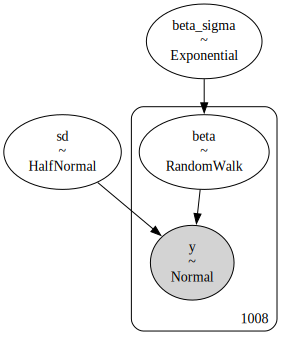

In [239]:
pm.model_to_graphviz(model)

In [177]:
# rolling_beta = idata.posterior['beta'].T.mean(axis=1)[:,0]#.mean(axis=1)
rolling_beta = idata.posterior['beta'].mean(dim=['draw','chain'])

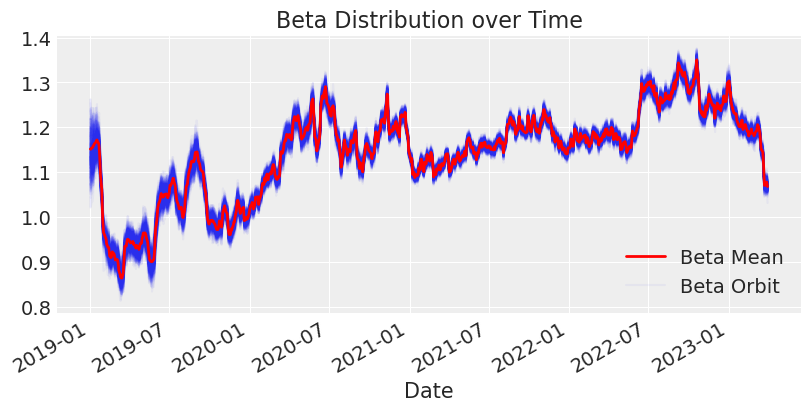

In [15]:
plt.figure(figsize = (8,4))
ax = plt.gca()
plt.title("Beta Distribution over Time")
pd.Series(rolling_beta,index=orig_data.index).plot(ax=ax,color='r',zorder=1e6,linewidth=2)

for orbit in idata.posterior['beta'].sel(draw=slice(0,300))[0]:
    pd.Series(orbit,index=orig_data.index).plot(ax=ax,color=sns.color_palette()[0],alpha=0.05)
    

plt.legend(['Beta Mean','Beta Orbit'])
plt.show()

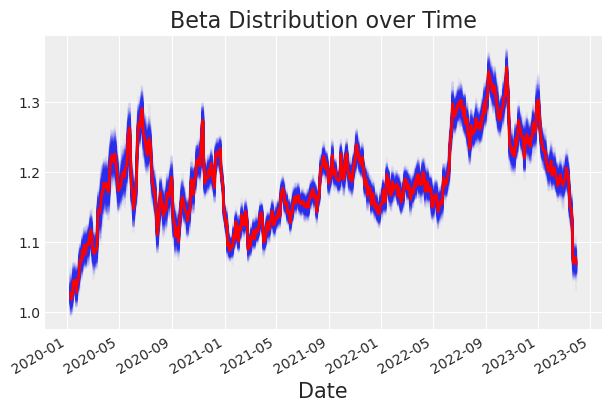

In [106]:
plt.figure(figsize = (6,4))
ax = plt.gca()
plt.title("Beta Distribution over Time")
pd.Series(rolling_beta[250:],index=orig_data.index[250:]).plot(ax=ax,color='r',zorder=1e6,linewidth=2, fontsize=10)

for orbit in idata.posterior['beta'].sel(draw=slice(0,300))[0]:
    pd.Series(orbit[250:],index=orig_data.index[250:]).plot(ax=ax,color=sns.color_palette()[0],alpha=0.05, fontsize=10)
    

# plt.legend(['Beta Mean','Beta Orbit'])
plt.show()

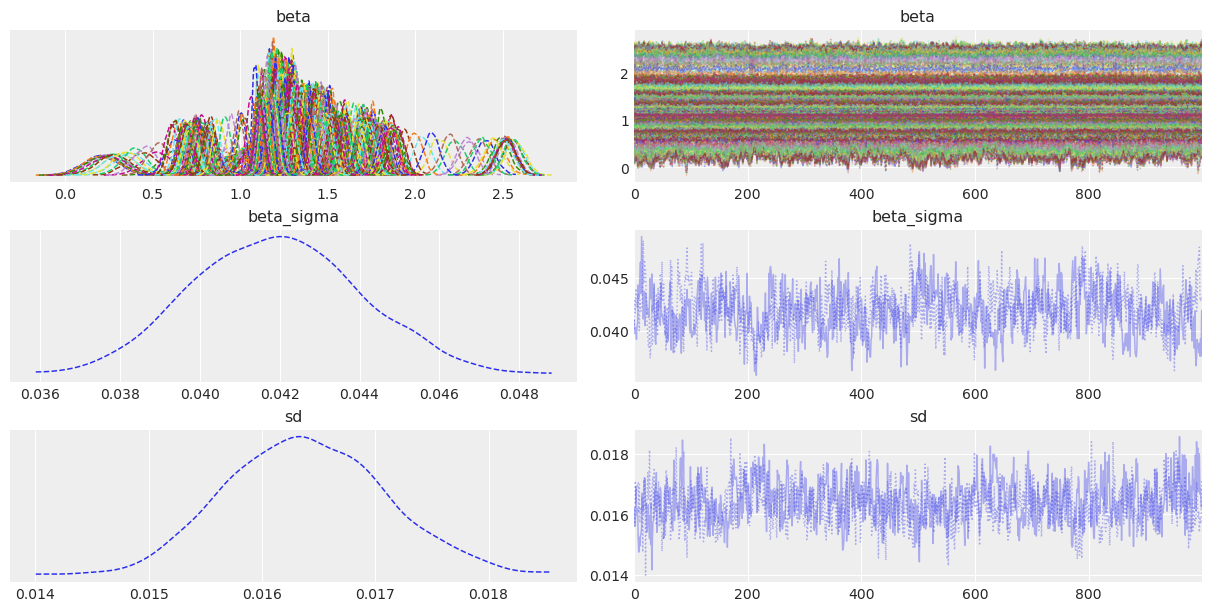

In [21]:
az.plot_trace(idata, combined=True);

In [14]:
def getStrategyPortfolioWeights(rolling_beta, stock_name1, stock_name2, data, smoothing_window=15):
    data1 = data[stock_name1].ffill().fillna(0).values
    data2 = data[stock_name2].ffill().fillna(0).values

    trading = "not"
    trading_start = 0
    leverage = 0*data.copy()
    
    signal_spot = pd.Series(np.zeros(data1.shape[0]), index=data.index)
    
    for i in range(smoothing_window, data1.shape[0]):
        leverage.iloc[i,:] = leverage.iloc[i-1,:]

        if trading=="not":
            # dynamically rebalance the signal when not trading
            fixed_beta = float(rolling_beta[i])
            signal = fixed_beta*data1 - data2
            smoothed_signal = pd.Series(signal).rolling(smoothing_window).mean()
            d_smoothed_signal = smoothed_signal.diff()
            
            signal_spot[i] = smoothed_signal[i]

            if smoothed_signal[i] > 0 and d_smoothed_signal[i] < 0:
                w0 = -fixed_beta / (abs(fixed_beta)+1)
                w1 = 1 / (abs(fixed_beta)+1)
                
                w_max = max(abs(w0), abs(w1))
                
                leverage.iloc[i,0] = w0 / w_max
                leverage.iloc[i,1] = w1 / w_max
                
                trading = "short"
                trading_start = smoothed_signal[i]
                
            else:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0

        elif trading=="short":
            signal_spot[i] = smoothed_signal[i]
            
            # a failed trade
            if smoothed_signal[i] > trading_start:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"

            # a successful trade
            if smoothed_signal[i] < 0:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"
                
    return leverage.fillna(0), signal_spot

In [15]:
def backtest(pricingDF, openDF, leverageDF, start_cash):
    pricing = pricingDF.values
    pricing_open = openDF.values
    leverage = leverageDF.values
    
    shares = np.zeros_like(pricing)
    cash = np.zeros(pricing.shape[0])
    cash[0] = cash[1] = start_cash
    curr_price = np.zeros(pricing.shape[1])
    
    total_cost = 0
    pnl_hist = np.zeros(pricing.shape[0])
    pnl = []
    values = np.zeros(pricing.shape[0])
    values[0] = values[1] = start_cash

    
    for t in range(2, pricing.shape[0]):
        if np.any(leverage[t-1] != leverage[t-2]):
            target_shares = (start_cash * leverage[t-1] / pricing[t-1]).astype(int)
            
            # rebalance
            shares[t] = target_shares
            cost0 = abs(shares[t,0] - shares[t-1,0]) * pricing_open[t,0] * 0.0001
            cost1 = abs(shares[t,1] - shares[t-1,1]) * pricing_open[t,1] * (0.00025 if shares[t,1] > shares[t-1,1] else 0.00225)

            cash[t] = cash[t-1] - ((shares[t]-shares[t-1]) * pricing_open[t]).sum() - cost0 - cost1
            total_cost += (cost0 + cost1)
            #set_trace()
            
        else:
            # maintain positions
            shares[t] = shares[t-1]
            cash[t] = cash[t-1]
            
        values[t] = (shares[t] * pricing[t]).sum() + cash[t]
            
        if shares[t-1,0]==0 and shares[t,0]!=0:
            pnl_hist[t] = values[t] - values[t-1]
            
        elif shares[t,0]!=0 or (shares[t-1,0]!=0 and shares[t,0]==0):
            pnl_hist[t] = pnl_hist[t-1] + values[t] - values[t-1]
            
        if shares[t-1,0]!=0 and shares[t,0]==0:
            pnl.append(pnl_hist[t])
    
    
    pct_returns = (values - start_cash) / start_cash
    
    n_days = pct_returns.shape[0]
    net_profit = int(values[-1] - start_cash)
    net_return = pct_returns[-1] * 100
    total_cost_rate = total_cost / (net_profit + total_cost) * 100
    n_entry = len(pnl)
    n_entry_monthly = n_entry / n_days * 20
    n_entry_days = (portfolioWeights.iloc[:,0] != 0).sum()
    n_holding_days = n_entry_days / n_entry
    pnl_by_entry = net_profit / n_entry
    profit_of_profit_entry = np.mean(list(filter(lambda x: x>0, pnl)))
    loss_of_loss_entry = np.mean(list(filter(lambda x: x<0, pnl)))

    print(f'테스트 일수: {n_days}일')
    print(f'순손익 (투자금액대비%): {format(net_profit, ",")}원 ({net_return:.3f}%)')
    print(f'총비용 (총손익대비%): {format(int(total_cost), ",")}원 ({total_cost_rate:.3f}%)')
    print(f'진입횟수: {n_entry}회')
    print(f'월평균 진입횟수: {n_entry_monthly:.2f}회')
    print(f'진입일수 (전체일수대비%): {n_entry_days}일 ({n_entry_days/n_days*100:.2f}%)')
    print(f'평균보유일수: {n_holding_days:.2f}일')
    print(f'진입당 평균손익: {format(int(pnl_by_entry), ",")}원')
    print(f'최대수익: {format(int(max(pnl)), ",")}원')
    print(f'최대손실: {format(int(min(pnl)), ",")}원')
    print(f'수익진입의 평균수익: {format(int(profit_of_profit_entry), ",")}원')
    print(f'손실진입의 평균손실: {format(int(loss_of_loss_entry), ",")}원')
    
    return (
        pd.DataFrame(shares, index=pricingDF.index, columns=pricingDF.columns),
        pd.Series(cash, index=pricingDF.index),
        pd.Series(pct_returns, index=pricingDF.index),
        pd.Series(values, index=pricingDF.index),
        pd.Series(pnl_hist, index=pricingDF.index),
        pd.Series(pnl)
    )

In [41]:
portfolioWeights, signal = getStrategyPortfolioWeights(rolling_beta, stock1_name, stock2_name, data, smoothing_window=1)#.fillna(0)
# portfolioWeights.plot(figsize=(6,4), ylim=(-1,1), fontsize=8)

<Axes: xlabel='Date'>

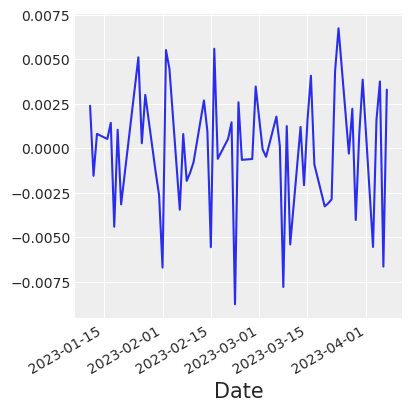

In [186]:
signal0.tail(60).plot(fontsize=10, figsize=(4,4))

In [218]:
#portfolioWeights.sum(axis=1).plot(figsize=(6,4), ylim=(-1,1), fontsize=8)

# 삼성전자

테스트 일수: 805일
순손익 (투자금액대비%): 18,673,418원 (18.673%)
총비용 (총손익대비%): 20,333,481원 (52.128%)
진입횟수: 88회
월평균 진입횟수: 2.19회
진입일수 (전체일수대비%): 161일 (20.00%)
평균보유일수: 1.83일
진입당 평균손익: 212,197원
최대수익: 2,822,662원
최대손실: -1,452,407원
수익진입의 평균수익: 747,308원
손실진입의 평균손실: -373,875원


<Axes: xlabel='Date'>

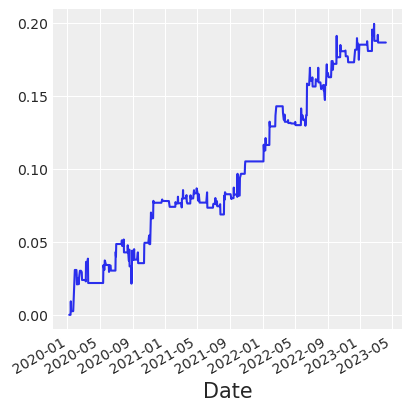

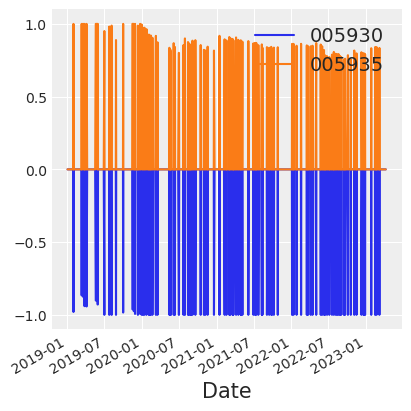

In [146]:
w0, signal0 = getStrategyPortfolioWeights(rolling_beta, stock1_name, stock2_name, data, smoothing_window=1)
shares0, cash0, returns0, values0, pnl_hist0, pnl0 = backtest(p_data[250:], p_open_data[250:], w0[250:], 1e8)
returns0.plot(figsize=(4,4), fontsize=10)
w0.plot(figsize=(4,4), fontsize=10)

In [147]:
w0.tail()

,005930,005935
Date,,
2023-04-03,0.0,0.0
2023-04-04,0.0,0.0
2023-04-05,0.0,0.0
2023-04-06,0.0,0.0
2023-04-07,0.0,0.0


<Axes: >

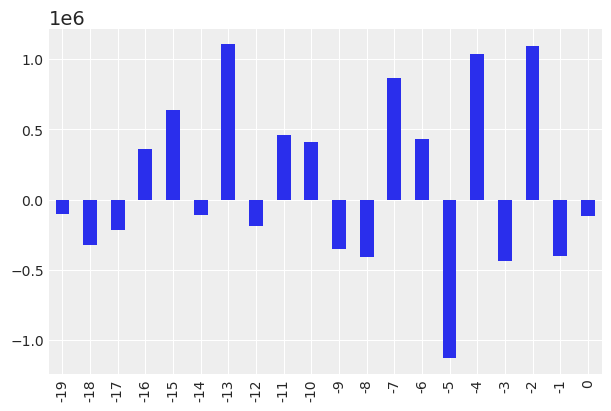

In [33]:
_pnl = pnl0.iloc[-20:]#.plot.bar()
_pnl.index = list(range(-19,1))
_pnl.plot.bar(figsize=(6,4), fontsize=10)

# LG전자

테스트 일수: 805일
순손익 (투자금액대비%): 38,173,670원 (38.174%)
총비용 (총손익대비%): 19,921,129원 (34.291%)
진입횟수: 86회
월평균 진입횟수: 2.14회
진입일수 (전체일수대비%): 161일 (20.00%)
평균보유일수: 1.87일
진입당 평균손익: 443,879원
최대수익: 3,165,114원
최대손실: -4,129,625원
수익진입의 평균수익: 1,271,767원
손실진입의 평균손실: -822,301원


<Axes: xlabel='Date'>

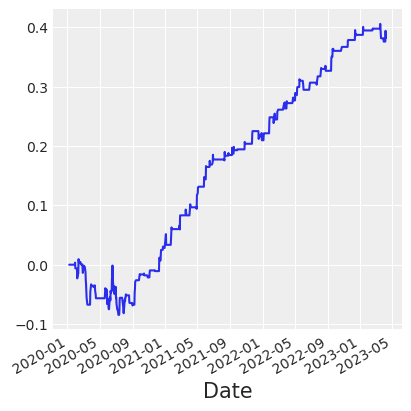

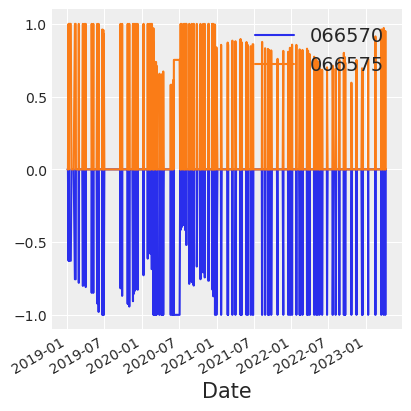

In [154]:
w1, signal1 = getStrategyPortfolioWeights(rolling_beta, stock1_name, stock2_name, data, smoothing_window=1)
shares1, cash1, returns1, values1, pnl_hist1, pnl1 = backtest(p_data[250:], p_open_data[250:], w1[250:], 1e8)
returns1.plot(figsize=(4,4), fontsize=10)
w1.plot(figsize=(4,4), fontsize=10)

In [155]:
w1.tail()

,066570,066575
Date,,
2023-04-03,0.0,0.00000
2023-04-04,0.0,0.00000
2023-04-05,-1.0,0.95125
2023-04-06,0.0,0.00000
2023-04-07,0.0,0.00000


# 삼성SDI

테스트 일수: 805일
순손익 (투자금액대비%): 81,523,699원 (81.524%)
총비용 (총손익대비%): 17,029,400원 (17.279%)
진입횟수: 80회
월평균 진입횟수: 1.99회
진입일수 (전체일수대비%): 161일 (20.00%)
평균보유일수: 2.01일
진입당 평균손익: 1,019,046원
최대수익: 11,341,820원
최대손실: -3,621,398원
수익진입의 평균수익: 1,811,742원
손실진입의 평균손실: -1,070,789원


<Axes: xlabel='Date'>

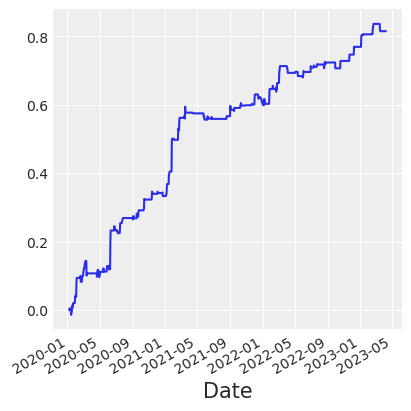

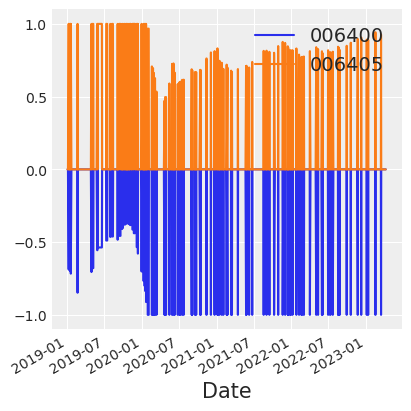

In [162]:
w2, signal2 = getStrategyPortfolioWeights(rolling_beta, stock1_name, stock2_name, data, smoothing_window=1)
shares2, cash2, returns2, values2, pnl_hist2, pnl2 = backtest(p_data[250:], p_open_data[250:], w2[250:], 1e8)
returns2.plot(figsize=(4,4), fontsize=10)
w2.plot(figsize=(4,4), fontsize=10)

In [163]:
w2.tail()

,006400,006405
Date,,
2023-04-03,0.0,0.0
2023-04-04,0.0,0.0
2023-04-05,0.0,0.0
2023-04-06,0.0,0.0
2023-04-07,0.0,0.0


# LG화학

테스트 일수: 805일
순손익 (투자금액대비%): 89,975,891원 (89.976%)
총비용 (총손익대비%): 25,499,608원 (22.082%)
진입횟수: 98회
월평균 진입횟수: 2.43회
진입일수 (전체일수대비%): 161일 (20.00%)
평균보유일수: 1.64일
진입당 평균손익: 918,121원
최대수익: 23,820,628원
최대손실: -8,726,143원
수익진입의 평균수익: 2,158,450원
손실진입의 평균손실: -1,762,589원


<Axes: xlabel='Date'>

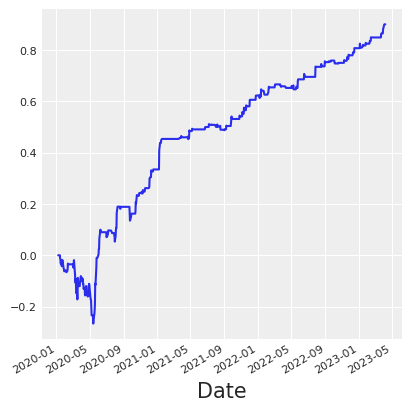

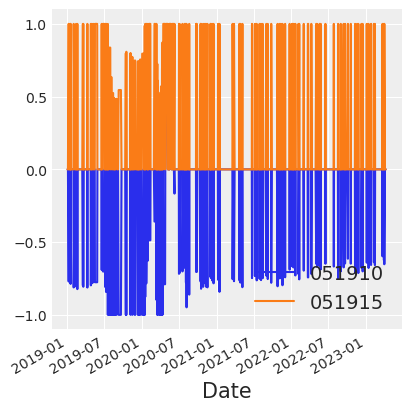

In [170]:
w3, signal3 = getStrategyPortfolioWeights(rolling_beta, stock1_name, stock2_name, data, smoothing_window=1)
shares3, cash3, returns3, values3, pnl_hist3, pnl3 = backtest(p_data[250:], p_open_data[250:], w3[250:], 1e8)
returns3.plot(figsize=(4,4), fontsize=8)
w3.plot(figsize=(4,4), fontsize=10)

In [171]:
w3.tail()

,051910,051915
Date,,
2023-04-03,0.0,0.0
2023-04-04,0.0,0.0
2023-04-05,0.0,0.0
2023-04-06,0.0,0.0
2023-04-07,0.0,0.0


# 현대차

테스트 일수: 805일
순손익 (투자금액대비%): 39,751,799원 (39.752%)
총비용 (총손익대비%): 26,384,200원 (39.894%)
진입횟수: 102회
월평균 진입횟수: 2.53회
진입일수 (전체일수대비%): 161일 (20.00%)
평균보유일수: 1.58일
진입당 평균손익: 389,723원
최대수익: 9,801,527원
최대손실: -4,021,175원
수익진입의 평균수익: 1,123,257원
손실진입의 평균손실: -845,701원


<Axes: xlabel='Date'>

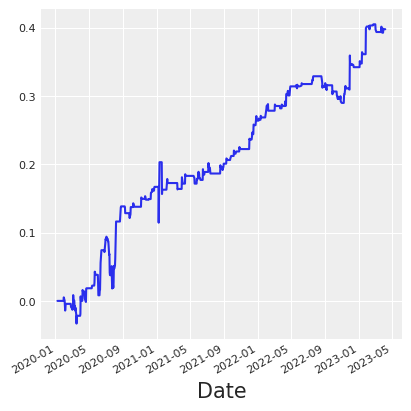

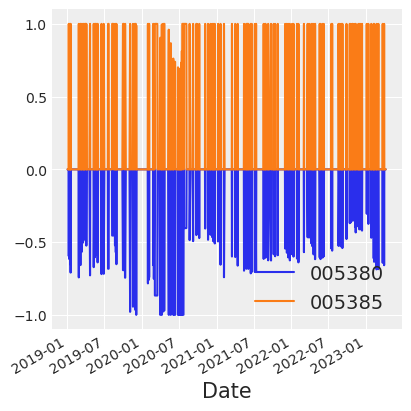

In [178]:
w4, signal4 = getStrategyPortfolioWeights(rolling_beta, stock1_name, stock2_name, data, smoothing_window=1)
shares4, cash4, returns4, values4, pnl_hist4, pnl4 = backtest(p_data[250:], p_open_data[250:], w4[250:], 1e8)
returns4.plot(figsize=(4,4), fontsize=8)
w4.plot(figsize=(4,4), fontsize=10)

In [179]:
w4.tail()

,005380,005385
Date,,
2023-04-03,0.0,0.0
2023-04-04,0.0,0.0
2023-04-05,0.0,0.0
2023-04-06,0.0,0.0
2023-04-07,0.0,0.0


# 삼성SDI + LG화학 + 현대차

<Axes: xlabel='Date'>

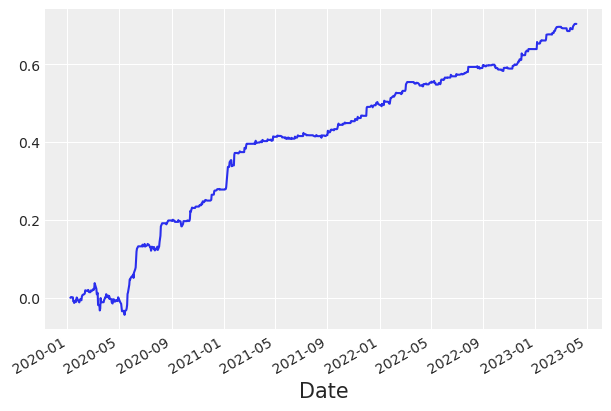

In [65]:
total_values = values2 + values3 + values4
((total_values / total_values.iloc[0]) - 1).plot(fontsize=10, figsize=(6,4))

<Axes: >

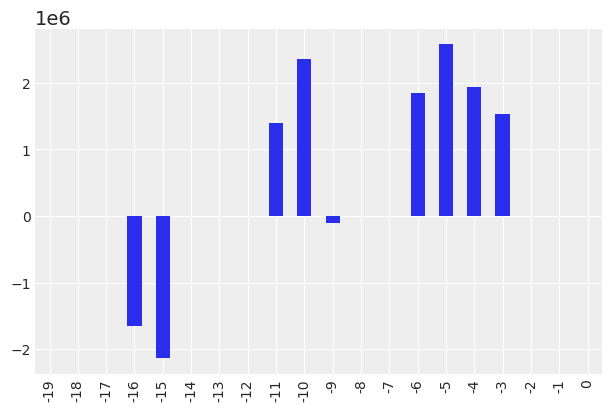

In [76]:
_pnl_total = (pnl_hist2 + pnl_hist3 + pnl_hist4).iloc[-20:]
_pnl_total.index = list(range(-19,1))
_pnl_total.plot.bar(figsize=(6,4), fontsize=10)